## Figure 3: Probabilities reconstructed to present day

This notebook reproduces Figure 3.

In [1]:
use_extracted_data = False

In [2]:
import os
from string import ascii_uppercase

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)

### Input and output files

In [3]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
model_dir = "plate_model"
check_plate_model(model_dir)

output_dir = os.path.join("figures")
os.makedirs(output_dir, exist_ok=True)

input_filename = os.path.join("outputs", "grid_probabilities.csv.zip")
coastlines_filename = os.path.join(
    model_dir,
    "StaticGeometries",
    "Coastlines",
    "Global_coastlines_low_res.shp",
)
training_filename = os.path.join(data_dir, "training_data.csv")

In [4]:
df = pd.read_csv(input_filename)
coastlines = gpd.read_file(coastlines_filename)
training_data = pd.read_csv(training_filename)

positives = training_data[training_data["label"] == "positive"]

### Plotting helper function

In [5]:
colours = (
    (0.0, "black"),
    (0.25, "grey"),
    (0.5, "cyan"),
    (0.75, "lightgreen"),
    (0.9, "yellow"),
    (0.95, "orange"),
    (1.0, "magenta"),
)
labels = (
    "Porphyry Cu deposits",
    "Very low prospectivity",
    "Low prospectivity",
    "Low-moderate prospectivity",
    "Moderate-high prospectivity",
    "High prospectivity",
    "Very high prospectivity",
)


def add_plot(df, ax, times, colours=colours, labels=labels, coastlines=coastlines, fontsize=None):
    min_time, max_time = times
    df_time = df[
        (df["age (Ma)"] >= min_time)
        & (df["age (Ma)"] <= max_time)
    ]

    for i in range(1, len(colours)):
        q1 = colours[i][0]
        colour = colours[i][1]
        q0 = colours[i - 1][0]
        label = labels[i]

        lower_bound = np.nanquantile(df_time["probability"], q0)
        upper_bound = np.nanquantile(df_time["probability"], q1)

        if i < len(colours) - 1:
            df_subset = df_time[
                (df_time["probability"] >= lower_bound)
                & (df_time["probability"] < upper_bound)
            ]
        else:
            df_subset = df_time[
                (df_time["probability"] >= lower_bound)
                & (df_time["probability"] <= upper_bound)
            ]
        if df_subset.shape[0] > 0:
            ax.plot(
                df_subset["present_lon"],
                df_subset["present_lat"],
                linestyle="none",
                marker="o",
                markerfacecolor=colour,
                markeredgecolor=colour,
                markersize=2.0,
                transform=ccrs.PlateCarree(),
                zorder=10 + i,
            )

    coastlines.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        facecolor="lightgrey",
        edgecolor="lightgrey",
        linewidth=1.0,
        zorder=0,
    )

    gl = ax.gridlines(
        draw_labels=True,
        zorder=50,
        linestyle="dashed",
        color="grey",
    )
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = False
    gl.right_labels = True

    ax.set_title("{} - {} Ma".format(max_time, min_time), fontsize=fontsize)

### North America

In [6]:
xlims = (-167, -85)
ylims = (13, 73)

time_windows = ((60, 80), (40, 60))

df_clipped = df[
    (df["present_lon"] >= xlims[0])
    & (df["present_lon"] <= xlims[1])
    & (df["present_lat"] >= ylims[0])
    & (df["present_lat"] <= ylims[1])
].copy()

df_clipped = gpd.GeoDataFrame(
    df_clipped,
    geometry=gpd.points_from_xy(
        df_clipped["present_lon"],
        df_clipped["present_lat"],
    ),
    crs=coastlines.crs,
)
df_clipped = gpd.clip(df_clipped, coastlines)

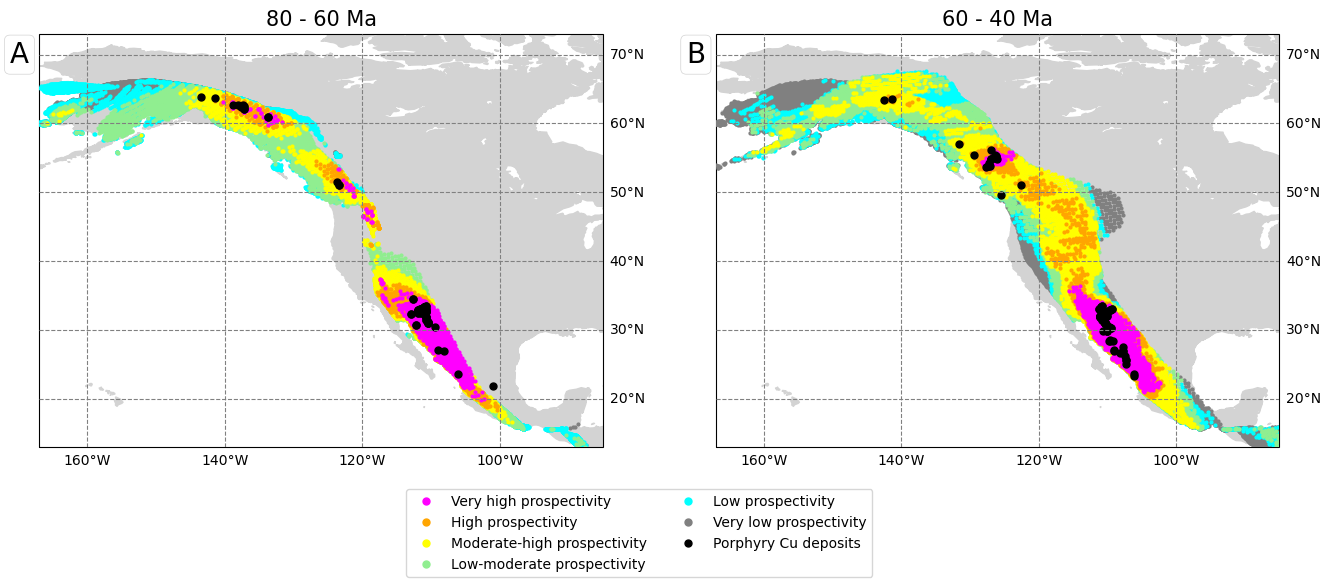

In [7]:
include_ellipses = False
output_basename = os.path.join(output_dir, "Fig-03a-DR_comparison_NA")

fig, axs = plt.subplots(
    1, 2,
    figsize=(16, 9),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for times, ax, label in zip(
    time_windows,
    np.ravel(axs),
    ascii_uppercase,
):
    add_plot(df_clipped, ax, times, fontsize=15)
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)

    positives_time = positives[
        (positives["age (Ma)"] >= times[0])
        & (positives["age (Ma)"] <= times[1])
    ]
    ax.plot(
        positives_time["present_lon"],
        positives_time["present_lat"],
        linestyle="none",
        marker="o",
        markerfacecolor="black",
        markeredgecolor="black",
        markersize=5,
        zorder=20,
        transform=ccrs.PlateCarree(),
    )
    ax.text(
        -0.035, 0.95,
        label,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=20,
        bbox=dict(
            facecolor="white",
            edgecolor="lightgrey",
            linewidth=0.5,
            boxstyle="Round, pad=0.2, rounding_size=0.2",
        )
    )

handles = []
for label, colour in zip(labels, colours):
    colour = colour[1]
    handle = Line2D(
        [], [],
        linestyle="none",
        marker="o",
        markerfacecolor=colour,
        markeredgecolor=colour,
        markersize=5,
    )
    handles.append(handle)
fig.legend(
    handles[::-1],
    labels[::-1],
    loc="center",
    bbox_to_anchor=(0.5, 0.17),
    ncols=2,
)

if include_ellipses:
    ellipses = [
        Ellipse(
            (-127.5, 55),
            width=13,
            height=7,
            angle=-35,
            facecolor="none",
            edgecolor="red",
            linewidth=2.0,
            zorder=1000,
            transform=ccrs.PlateCarree(),
        ),
        Ellipse(
            (-127.5, 55),
            width=13,
            height=7,
            angle=-35,
            facecolor="none",
            edgecolor="black",
            linewidth=3.0,
            zorder=999,
            transform=ccrs.PlateCarree(),
        ),
    ]
    for i in ellipses:
        axs[1].add_patch(i)

for extension in (".png", ".pdf"):
    fig.savefig(output_basename + extension, dpi=350, bbox_inches="tight")

### South America

In [8]:
xlims = (-85, -60)
ylims = (-60, 11)

time_windows = ((3, 23), (27, 47), (47, 66))

df_clipped = df[
    (df["present_lon"] >= xlims[0])
    & (df["present_lon"] <= xlims[1])
    & (df["present_lat"] >= ylims[0])
    & (df["present_lat"] <= ylims[1])
].copy()

df_clipped = gpd.GeoDataFrame(
    df_clipped,
    geometry=gpd.points_from_xy(
        df_clipped["present_lon"],
        df_clipped["present_lat"],
    ),
    crs=coastlines.crs,
)
df_clipped = gpd.clip(df_clipped, coastlines)

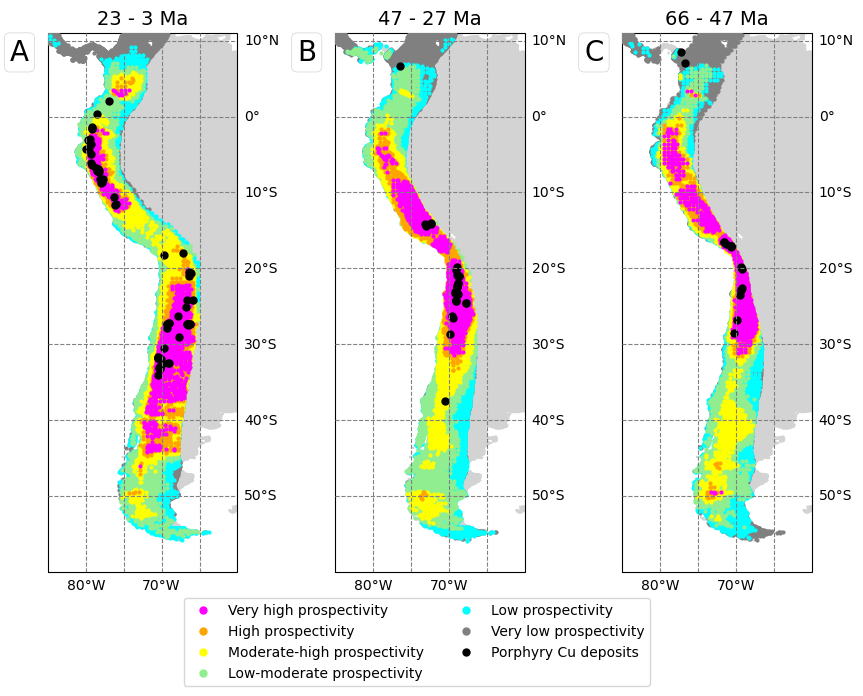

In [9]:
output_basename = os.path.join(output_dir, "Fig-03b-DR_comparison_SA")

fig, axs = plt.subplots(
    1, 3,
    figsize=(10.5, 7),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for times, ax, label in zip(
    time_windows,
    np.ravel(axs),
    ascii_uppercase,
):
    add_plot(df_clipped, ax, times, fontsize=14)
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)

    positives_time = positives[
        (positives["age (Ma)"] >= times[0])
        & (positives["age (Ma)"] <= times[1])
    ]
    ax.plot(
        positives_time["present_lon"],
        positives_time["present_lat"],
        linestyle="none",
        marker="o",
        markerfacecolor="black",
        markeredgecolor="black",
        markersize=5,
        zorder=20,
        transform=ccrs.PlateCarree(),
    )
    ax.text(
        -0.15, 0.99,
        label,
        horizontalalignment="center",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=20,
        bbox=dict(
            facecolor="white",
            edgecolor="lightgrey",
            linewidth=0.5,
            boxstyle="Round, pad=0.2, rounding_size=0.2",
        )
    )

handles = []
for label, colour in zip(labels, colours):
    colour = colour[1]
    handle = Line2D(
        [], [],
        linestyle="none",
        marker="o",
        markerfacecolor=colour,
        markeredgecolor=colour,
        markersize=5,
    )
    handles.append(handle)
fig.legend(
    handles[::-1],
    labels[::-1],
    loc="center",
    bbox_to_anchor=(0.5, 0.01),
    ncols=2,
)

for extension in (".png", ".pdf"):
    fig.savefig(output_basename + extension, dpi=350, bbox_inches="tight")